In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
using DataFrames;
import NLsolve,Roots;
# pyplot(frame=:box,size=(500,350));
# set default values for the pyplot backend of Plots
pyplot(frame=:box, minorticks=5, size=(500,350), titlefont = (11,"serif"), 
    guidefont = (12,"serif"), tickfont = (11,"serif"), legendfont= (9, "serif"),
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto) 
# # mathtext.fontset; supported: ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
# PyPlot.matplotlib.rc("mathtext", fontset="cm")      
# PyPlot.matplotlib.rc("font", family="serif", size=11)

Plots.PyPlotBackend()

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potential.jl");

In [30]:
# ----------------------------------------------------------DD*----------------------------------------------------#
function potential_DnDsc(E,p, q; I=0, a=0, cl=:ss,a1=0.0)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
    res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += real(-4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0, cl=:ss,a1=0.0)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
    res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += real(-4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0, cl=:ss,a1=0.0)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += real(2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -2 * g^2 / (3fπ^2) / sqrt(16) * (pwa_tensor(p, q, mη^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mη^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρn^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρn^2 - q02^2; cl=cl)
                                           -
                                           pwa_square(p, q, mρn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += ((2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mω^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mω^2 - q02^2; cl=cl)
                                          -
                                          pwa_square(p, q, mω^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    #ηc,J/ψ
    res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(p, q, mηc^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mηc^2 - q02^2; cl=cl)) * (-2) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mJψ^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mJψ^2 - q02^2; cl=cl)
                                           -
                                           pwa_square(p, q, mJψ^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2*(-2))
    return res
end

potential_DDscross (generic function with 1 method)

In [3]:
function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

# width of $D^*$

In [4]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

dΓf3 (generic function with 1 method)

In [5]:
ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

dΓDsnf (generic function with 1 method)

In [6]:
function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    @assert sol.residual_norm < 1e-8 "The on-shell momentum not found!"
    return sol.zero[1] + im * sol.zero[2]
#     return sol.residual_norm < 1e-8 ? sol.zero[1] + im * sol.zero[2] : NaN+im*NaN
end

find_singular (generic function with 1 method)

In [7]:
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

# path deformation

In [8]:
xxx,www=gauss(30,0,1);

In [9]:
function Einner(E,q,m1,m2,m3,m12)
    return E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
end

Einner (generic function with 1 method)

In [10]:
function find_qint(E,m1,m2,m3,m12;rtol=1e-6)
    function f!(F,x)
        q=x[1]+1.0im*x[2]
        tmp=Einner(E,q,m1,m2,m3,m12)
        F[1]=real(tmp)-m1-m2
        F[2]=imag(tmp)-rtol
    end
    sol=NLsolve.nlsolve(f!,[0.1,-0.1])
    return sol.zero[1]+im*sol.zero[2]
end

find_qint (generic function with 1 method)

$0\sim 0.5$, $0.5\sim 1$, $1\sim\infty$

In [11]:
f1(x)=0.5*x;
f2(x)=0.5*(1-x)+1.0*x;
f3(x)=1.0+tan(π/2*x);
df3(x)=π/2/cos(π/2*x)^2;

In [12]:
function find_qw(E)
    # wi is the one wrappered with g'(x)
    qon=[qon_c(E),qon_0(E)]
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        qi=vcat(f1.(xxx),f2.(xxx),f3.(xxx))
        wi=vcat(0.5 .*www,0.5 .*www,df3.(xxx) .*www)
        return qon,qi,wi
    end
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    println(qint1,qint2)
    # get points
    qint3=Roots.find_zero(x->imag(conj(qint2-qint1)*(x-qint1)),(0,Inf))
    
    qi=vcat(qint1 .*xxx,qint1 .+ ((qint3-qint1) .*xxx),qint3 .+(tan.(π/2 .*xxx)))
    wi=vcat(qint1 .*www,(qint3-qint1) .*www,df3.(xxx) .*www)
    return qon,qi,wi
end

find_qw (generic function with 1 method)

In [13]:
function find_qw1(E)
    # wi is the one wrappered with g'(x)
    qon=[qon_c(E),qon_0(E)]
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        qi=vcat(qon,f1.(xxx),f2.(xxx),f3.(xxx))
        wi=vcat(0.5 .*www,0.5 .*www,df3.(xxx) .*www)
        return qi,wi
    end
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    
    # get points on real axis
    qint3=Roots.find_zero(x->imag(conj(qint2-qint1)*(x-qint1)),(0,Inf))
    
    qi=vcat(qon,qint1 .*xxx,qint1 .+ ((qint3-qint1) .*xxx),qint3 .+(tan.(π/2 .*xxx)))
    wi=vcat(qint1 .*www,(qint3-qint1) .*www,df3.(xxx) .*www)
    return qi,wi
end

find_qw1 (generic function with 1 method)

In [15]:
function VMat(E;a = 0.0,a1=0.0)
    vmat=zeros(ComplexF64,2,2)
    k1,k2=qon_c(E),qon_0(E)
    vmat[1,1] = potential_DnDsc(E,k1,k1; a = a,a1=a1, cl = :ss)
    vmat[1,2] = potential_DDscross(E,k2,k1; a = a,a1=a1,  cl = :ss)
    vmat[2,1] = potential_DDscross(E,k1,k2; a = a,a1=a1,  cl = :ss)
    vmat[2,2] = potential_DcDsn(E,k2,k2; a = a,a1=a1,  cl = :ss)
    return vmat
end

VMat (generic function with 1 method)

In [16]:
eigvals(VMat(mDn+mDsc-360e-6-im*24e-6))|>println
DataFrame(VMat(mDn+mDsc-360e-6-im*24e-6),:auto) #only \rho,jpsi

ComplexF64[-16.082425617644986 - 0.47948537665836477im, 25.384690220675875 - 0.5793605332132162im]


,x1,x2
,Complex…,Complex…
1,2.2972-0.0733902im,20.6045+0.00184849im
2,20.6045+0.00184849im,7.00507-0.985456im


In [17]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [18]:
function GMat(E;Λ1=0.5,Λ2=0.5)
    qi,wi=find_qw1(E)
    k1,k2,qau=qi[1],qi[2],qi[3:end]
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    
    g11=sum(broadcast(l->(l^2*exp(-2*l^2/Λ1^2)-k1^2*exp(-2*k1^2/Λ1^2))*Gc(E,l),qau) .*wi)+im/(2π)*k1^2*exp(-2*k1^2/Λ1^2)/(-k1/μ1+im*dΓDscf(E,k1)/2)
    g33=sum(broadcast(l->(l^2*exp(-2*l^2/Λ2^2)-k2^2*exp(-2*k2^2/Λ2^2))*Gn(E,l),qau) .*wi)+im/(2π)*k2^2*exp(-2*k2^2/Λ2^2)/(-k2/μ2+im*dΓDsnf(E,k2)/2)
    return diagm([g11,g33])
end

GMat (generic function with 1 method)

In [19]:
function TMat(E;a = 0.0,a1=0.0,Λ1=0.5,Λ2=0.5)
    vv=VMat(E;a=a,a1=a1)
    gg=GMat(E;Λ1=Λ1,Λ2=Λ2)
    return inv(LinearAlgebra.I-vv*gg)*vv
end

TMat (generic function with 1 method)

In [20]:
function detVG(E;a = 0.0,a1=0.0,Λ1=0.5,Λ2=0.5)
    vv=VMat(E;a=a,a1=a1)
    gg=GMat(E;Λ1=Λ1,Λ2=Λ2)
    return det(LinearAlgebra.I-vv*gg)
end

detVG (generic function with 1 method)

# optimization

In [21]:
using Optim;
# import BlackBoxOptim;

In [22]:
function absdet(x;E=mDn+mDsc-360e-6-im*24e-6)
    return abs(detVG(E;a=x[1],Λ1=x[2],Λ2=x[3]))
end

absdet (generic function with 1 method)

In [23]:
function inv_abst(x;E=mDn+mDsc-360e-6-im*24e-6)
    return 1/abs(TMat(E;a=x[1],Λ1=x[2],Λ2=x[3])[1,1])
end

inv_abst (generic function with 1 method)

In [24]:
function plotdetvg(x)
    Ev=collect(3.873:0.0001:3.877)
    Γv=collect(-100e-6:5e-6:100e-6)#collect(-500e-6:10e-6:500e-6)
    resv=[1/abs(detVG(e+im*γ;a=x[1],Λ1=x[2],Λ2=x[3])) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsc],ls=:dot)
    vline!([mDc+mDsn],ls=:dot)
end

plotdetvg (generic function with 1 method)

In [25]:
function plottmatrix(x)
    Ev=collect(3.873:0.00001:3.877)
    resv=[abs(TMat(e;a=x[1],Λ1=x[2],Λ2=x[3])[1,1]) for e in Ev]
    plot(Ev,resv)
    vline!([mDn+mDsc],ls=:dot)
    vline!([mDc+mDsn],ls=:dot)
end

plottmatrix (generic function with 1 method)

In [26]:
function searchminumum(x)
    loss(y)=abs(detVG(y[1]+im*y[2];a=x[1],Λ1=x[2],Λ2=x[3]))
    init_val=[mDn+mDsc-360e-6,-24e-6]
    lower=[mDn+mDsc-400e-6,-100e-6]
    upper=[mDn+mDsc-200e-6,-10e-6]
    res=Optim.optimize(loss,lower,upper,init_val)
    return Optim.minimum(res),Optim.minimizer(res)
end

searchminumum (generic function with 1 method)

## same $\Lambda$ and a=0

0.0010427239276960128
[1.0767166970764765]


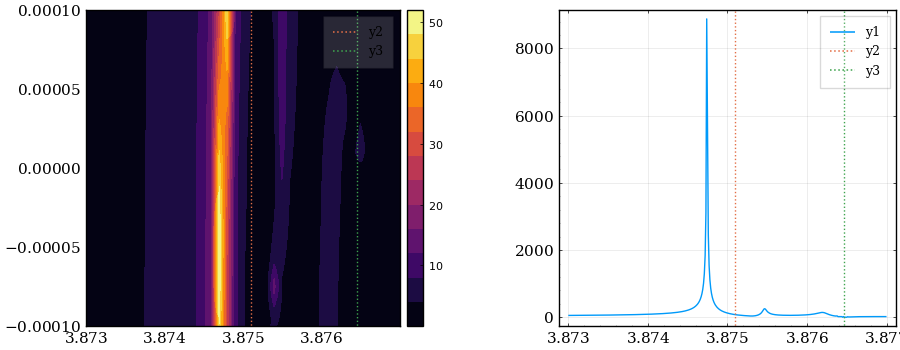

In [31]:
let 
    tmpf(x)=absdet([0.0,x[1],x[1]];E=mDn+mDsc-360e-6-im*24e-6)
#     tmpf(x)=inv_abst([0.0,x[1],x[1]];E=mDn+mDsc-360e-6)
    init_val=[0.6]
    lower=[0.3]
    upper=[2.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
    
    Λ=Optim.minimizer(res)[1]
    p1=plotdetvg([0.0,Λ,Λ])
    p2=plottmatrix([0.0,Λ,Λ])
    plot(p1,p2,layout=(1,2),size=(900,350))
end

In [68]:
searchminumum([0.0,0.6945451891051765,0.6945451891051765])

(0.0006892997699338891, [3.8747390424973633, -2.356972271294093e-5])

## same $\Lambda$ and 0-a-1

0.19417987877413884
[9.617941652220288e-9, 0.9999999964118359]


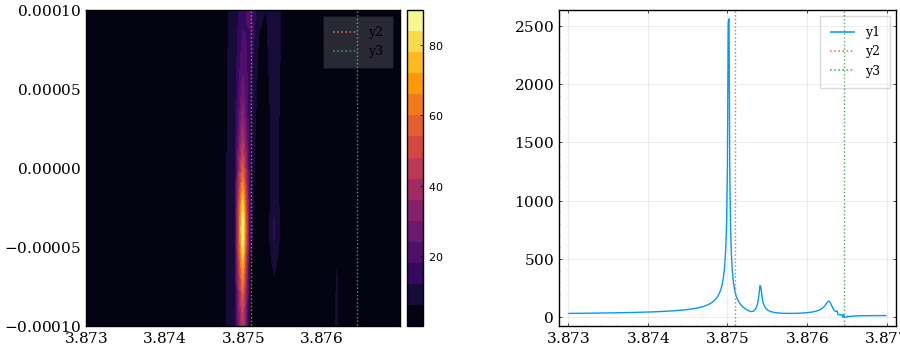

In [32]:
let 
    tmpf(x)=absdet([x[1],x[2],x[2]];E=mDn+mDsc-360e-6-im*24e-6)
#     tmpf(x)=inv_abst([x[1],x[2],x[2]];E=mDn+mDsc-360e-6)
    init_val=[0.01,0.5]
    lower=[0.0,0.3]
    upper=[1.0,1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
    
    a,Λ=Optim.minimizer(res)
    p1=plotdetvg([a,Λ, Λ])
    p2=plottmatrix([a,Λ, Λ])
    plot(p1,p2,layout=(1,2),size=(900,350))
end

In [70]:
searchminumum([0.9999999999670529, 0.8848809409439643,0.8848809409439643])

(0.0001365723624380163, [3.8747399999903824, -2.400000138583937e-5])